In [3]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [8, 5]
from scipy.integrate import solve_ivp

Populating the interactive namespace from numpy and matplotlib


## Problem 1e

In order to perform an integral numerically, we are approximating:

$$y(b) - y(a) = \int_a^b f(x)dx = \int_a^b \frac{dy}{dx}(x)dx$$

Note that we are solving for a velocity increment, or difference which is precisely the
left-hand side of the equation above.

We can approximate its solution simply using the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule):

$$\int_a^b f(x)dx = \frac{\Delta x}{2}\left[f(a) + 2 \sum_{k=1}^{N-1}f(x_k) + f(b)\right]$$

In [4]:
def integrate_trap(f, a, b, args=None, N=100):
    '''
    Uses trapezoidol rule to approximate
    integrate of f(x) from a to b
    '''
    delta_x = (b-a) / float(N)
    xk = np.linspace(a + delta_x, b - delta_x, N-1)
    return delta_x / 2. * (f(a, *args) + 2 * np.sum(f(xk, *args)) + f(b, *args))

Let's try this out with the rocket equation.  The rocket equation was originally derived from conservation of momentum which states that:

$$m dU_r = U_e dm$$

or

$$dU_r = U_e \frac{dm}{m}$$

We know the solution to this is

$$\Delta U_r = U_e \ln{\frac{m_i}{m_f}}$$

Let's compare this with numerical solution.  To do so we'll use a case that's similar but not the same as yours.  In this case, we'll assume we have a pump, rather than compressed air, that is accelerating the water out of the water rocket.

The pump requires batteries to power it, and the batteries have mass.  In fact, for lithium ion batteries at reasonable discharge rates, the *energy density* of the batteries is about $k_{b} = $ **500 kJ / kg**.  This means that given a total required energy to run the pump in our rocket, we can compute the mass of the batteries:

$$m_b = \frac{E}{k_{b}}$$

How much energy does it take to expel the water?  For a perfectly efficient pump accelerating the water to $U_e$, by conservation of energy:

$$dE_{ideal} = \frac{U_e^2}{2}dm$$

Of course in reality our pump will not be perfectly efficient so we will assume a constant pump efficiency (electrical plus hydraulic) of $\eta_{p}=$ 0.50.

$$dE = \frac{\eta U_e^2}{2}dm$$

Integrating this is straightforward and we arrive at:

$$E = \frac{\eta U_e^2}{2}m_p$$

where $m_p$ the propellant mass.  And thus battery mass is:

$$m_b = \frac{\eta U_e^2}{2 k_b}m_p$$

If we also assume that the dry rocket mass (structure mass) is directly proportional to the amount of propellant we have to carry

$$m_s = \alpha m_p$$ we can derive the following for the rocket *mass ratio*:

$$\frac{m_i}{m_f} = \frac{m_p\left[1 + \alpha + \frac{\eta U_e^2}{2 k_b}\right]}{m_p\left[\alpha + \frac{\eta U_e^2}{2 k_b}\right]} = \frac{1 + \alpha + \frac{\eta U_e^2}{2 k_b}}{\alpha + \frac{\eta U_e^2}{2 k_b}}$$

So finally the closed form solution is:

$$\Delta U_r = U_e \ln{\left[\frac{1 + \alpha + \frac{\eta U_e^2}{2 k_b}}{\alpha + \frac{\eta U_e^2}{2 k_b}}\right]}$$

In [5]:
def f_rocket_equation(m, Ue):
    return Ue / m

Ue = 100.
alpha = 0.1
eta_p = 0.5
k_b = 500e3

mi = 1. + alpha + eta_p * Ue**2 / 2 / k_b
mf = alpha + eta_p * Ue**2 / 2 / k_b

deltaU_r_analytical = Ue * np.log(mi/mf)

deltaU_r_numerical = integrate_trap(f_rocket_equation, mf, mi, args=(Ue,))

print('Analytic results: %.3f m/s' % deltaU_r_analytical)
print('Numerical results: %.3f m/s' % deltaU_r_numerical)

Analytic results: 235.364 m/s
Numerical results: 235.439 m/s


Pretty close!

Now let's look at something a bit closer to the problem you are asked to solve.

How does $\Delta U_r$ vary with our choice of Ue?  We'll do this purely with the numerical solution as that's what you will need to do.

Text(0,0.5,'$\\Delta U_r$ (m/s)')

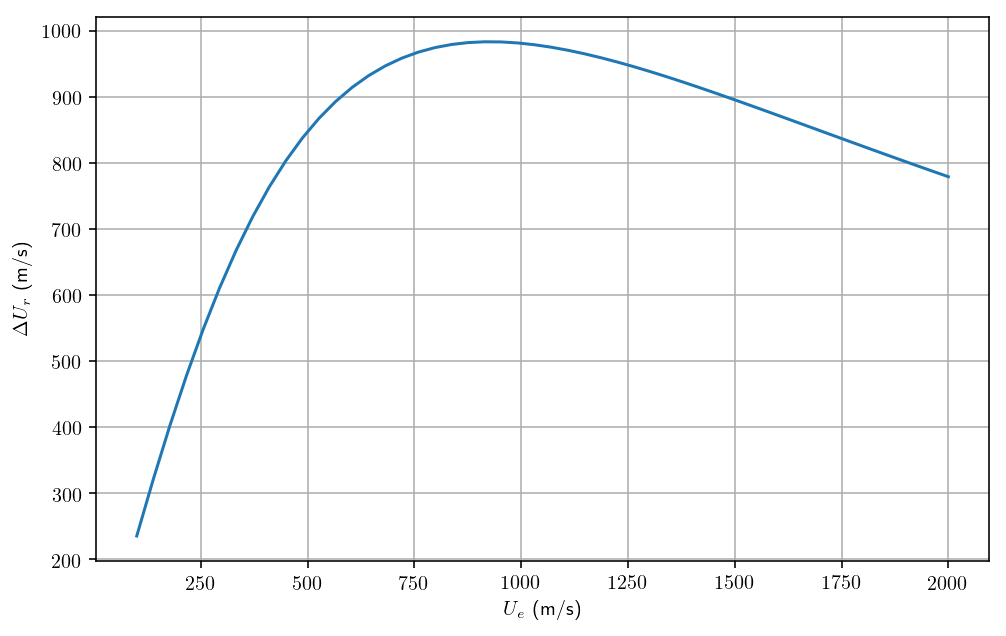

In [6]:
Uev = np.linspace(100, 2e3)
deltaU_v = np.zeros_like(Uev)

for i, Ue in enumerate(Uev):
    mi = 1. + alpha + eta_p * Ue**2 / 2 / k_b
    mf = alpha + eta_p * Ue**2 / 2 / k_b
    deltaU_v[i] = integrate_trap(f_rocket_equation, mf, mi, args=(Ue,))
    
plt.plot(Uev, deltaU_v)
plt.xlabel(r'$U_e$ (m/s)')
plt.ylabel(r'$\Delta U_r$ (m/s)')

## Problem 2

We'll give an example for numerical integration of a 1D trajectory for the case above.  While the $\Delta V$ result is useful, it's not clear that it gives the right optimal point for the case with drag and gravity.

In this case we'll need to both solve Newton's first law for the trajectory but also track the amount of propellant we've expelled at the same time.

For this example, the mass tracking is actually very easy.  

$$\frac{dm}{dt} = -U_e A_e \rho_w$$

where $\rho_w$ is the density of water.  We could actually compute the remaining mass of the rocket in closed form given a $U_e$ and $A_e$ but in your problem you will not be able to so we will show the numerical solution here.

Alongside the ODE for mass above we seek to solve the trajectory in 1D.  Newton's first law states

$$m\ddot{y} = \sum F = F_T - F_D - F_g$$

where $F_T$ is thrust force, $F_D$ is drag force and $F_g$ is gravitational body force.  We can re-write this as

$$\ddot{y} = \frac{T(t) - D(t)}{m(t)} - g_0$$

Thrust is just

$$T = \dot{m} U_e$$

and drag is

$$D(t) = \frac{1}{2}\rho_{amb}\dot{y}^2$$

where $\rho_{amb}$ is ambient atmospheric air density, NOT the density in the bottle.

Because the trajectory depends on variables related to the first ODE, we must solve these two simulatenously.  There is doable in closed-form so we will re-formulate this as a state-space problem and numerically integrate the state space equation.

$$\begin{gather}
    d\begin{bmatrix}
        \dot{y}\\
        y\\
        m
    \end{bmatrix} =  
    \begin{bmatrix}
        \frac{\dot{m}U_e - \frac{1}{2}\rho_{amb}\dot{y}^2}{m_{air}}-g0\\
        \dot{y}\\
        -U_e A_e \rho_w
    \end{bmatrix}
\end{gather}$$

Assume $C_d = 0.4$ for the analysis or if you're feeling energetic [estimate using this](https://iopscience.iop.org/article/10.1088/0143-0807/30/5/012/pdf).

## Numerical integration

For this analysis, we'll look at two different ODE integration methods - Euler and midpoint.  They are both first-order, single-step explicit methods and are really the simplest of the numerical integration methods.  First order methods are simple to understand and debug which is why I've provided them for you, but they're quite inefficient - in order to get good accuracy you have to make the step sizes very small.  I also want to show how to use a Runge-Kutta fourth-order method that is provided in the [SciPy](https://docs.scipy.org). 

Euler and Midpoint are pretty simple schemes and it's good to know how they work but don't spend too much time on it - I've provided the functions for you in a general form that will work to solve your problem as well.  If you decide to use the Runge-Kutta method, I recommend starting with Euler or Midpoint as it will be easier to debug if you run into issues.

In [7]:
def euler_integrate(df, t0, tf, x0, N=100):
    '''
    Given an ODE dx = f(t, x) 
    integrates the ODE from t0 to tf
    over N steps and returns the result.
    '''
    x = np.zeros([N, len(x0)])
    t = np.linspace(t0, tf, N)
    dt = (tf - t0) / float(N)
    x[0, :] = x0
    df0 = df(t0, x0)
    for i in range(1,N):
        x[i, :] = x[i-1, :] + dt * df(t[i], x[i-1, :])
    
    return t, x

def midpt_integrate(df, t0, tf, x0, N=100):
    '''
    Given an ODE dx = f(t, x) 
    integrates the ODE from t0 to tf
    over N steps and returns the result.
    '''
    x = np.zeros([N, len(x0)])
    t = np.linspace(t0, tf, N)
    dt = (tf - t0) / float(N)
    x[0, :] = x0
    df0 = df(t0, x0)
    df_last = df0
    for i in range(1,N):
        x[i, :] = x[i-1, :] + dt * df(t[i] + dt / 2., x[i-1, :] + dt / 2. * df_last)
    
    return t, x

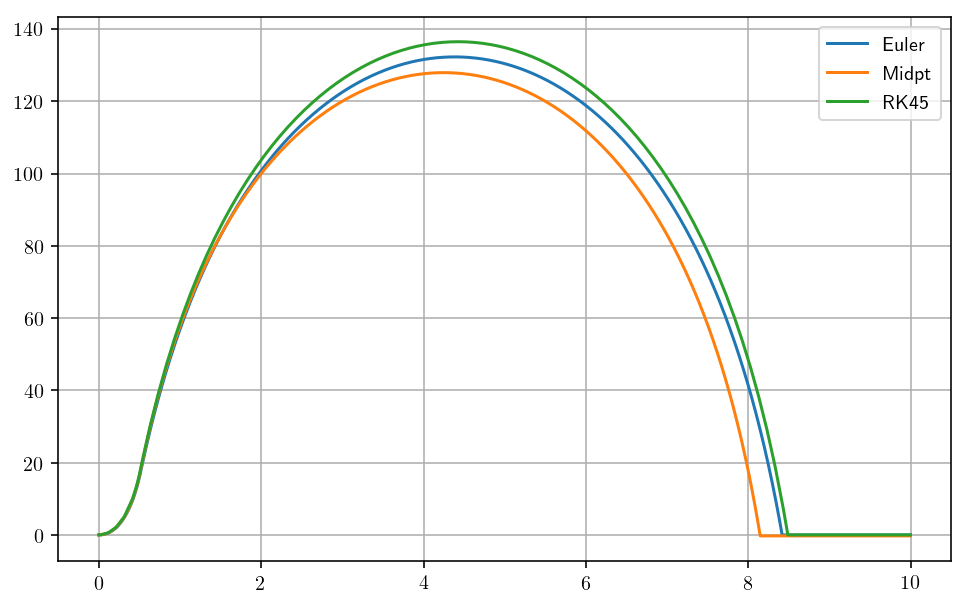

In [12]:
rho_a = 1.2           #kg/m^3
rho_w = 1000.         #kg/m^3
Cd = 0.4
Af = pi * (11e-2)**2 / 4.   # m^2
Ae = pi * (1e-2)**2 / 4.    # m^2
g0 = 9.81                   # m/s^2

alpha = 0.1
eta_p = 0.5
k_b = 500e3

Ue = 50.
Vt = 2. * 1e-3       # m^3
mp = Vt * rho_w
ms = alpha * mp
mb = eta_p * Ue**2 / 2 / k_b
m0 = mp + ms + mb

def df(t, x):
    yd = x[0]
    y = x[1]
    m = x[2]
    
    dx = np.zeros([3])
    
    # Note that in this example we don't really
    # need to compute mdot within the integration
    # because it's constant.  But for your problem
    # it will change as the rocket expels water so
    # I wanted to show that here.  You will also
    # need to compute Ue during the expulsion process of
    # of course!
    mdot = Ue * Ae * rho_w
    
    # Check if we've hit the ground
    if y < 0.:
        dx[0] = 0.
        dx[1] = 0.
        dx[2] = 0.
    # Check if we've expended all the water
    elif m <= (ms + mb):
        dx[0] = ((- 0.5 * Cd * Af * rho_a * yd**2) / m - g0)
        dx[1] = yd
        dx[2] = 0.
    # We're still thrusting!
    else:
        dx[0] = ((mdot * Ue - 0.5 * Cd * Af * rho_a * yd**2) / m - g0)
        dx[1] = yd
        dx[2] = -mdot
    
    return dx

t, x = euler_integrate(df, 0, 10, [0, 0, m0], N=1000)
t1, x1 = midpt_integrate(df, 0, 10, [0, 0, m0], N=1000)
s_rk45 = solve_ivp(df, [0, 10], [0, 0, m0], method='RK45', 
                   max_step=0.1, vectorized=True)
plt.plot(t, x[:,1], label='Euler')
plt.plot(t1, x1[:,1], label='Midpt')
plt.plot(s_rk45.t, s_rk45.y[1,:], label='RK45')
plt.legend()

## Multi-variate optimization

Now we will look at how trajectory performance varies over a couple of variables - nozzle size and water exit velocity.  Note that to get the point across, I've had to take some liberties on this particular problem and adjust water density and battery energy density.  For your problem, you will need to take no such liberties.

Text(0,0.5,'$d_t (cm)$')

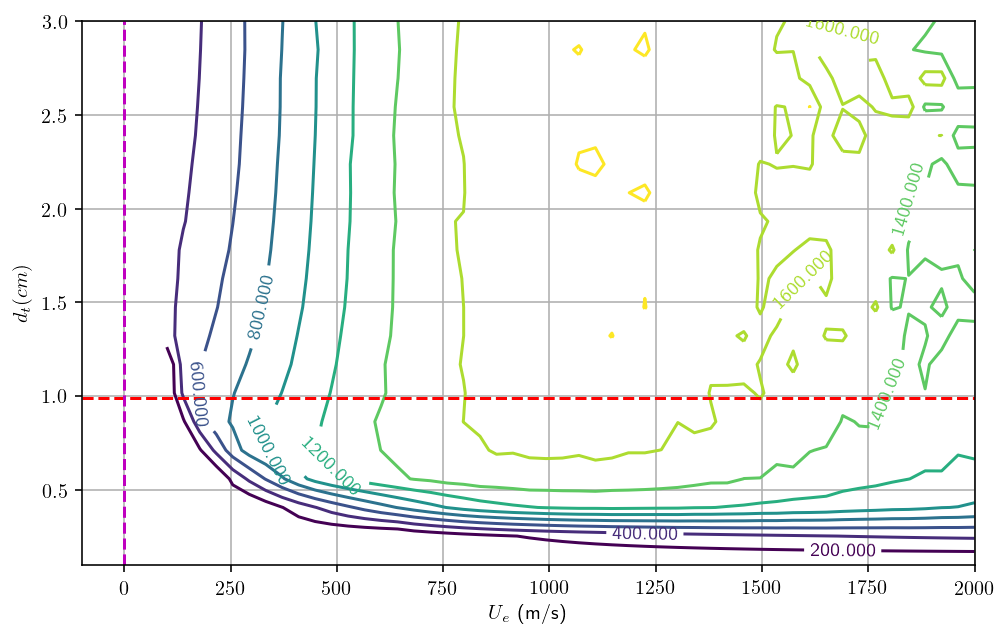

In [14]:
dt_v = np.linspace(0.1e-2, 3e-2, 20)
Uev = np.linspace(100, 2000)

altv = np.zeros([len(dt_v), len(Uev)])
rho_w = 20.
alpha = 0.1
eta_p = 0.5
k_b = 50e3
ms = alpha * mp

for i, d in enumerate(dt_v):
    for j, Ue in enumerate(Uev):
        mb = eta_p * Ue**2./ 2 / k_b
        m0 = mp + ms + mb
        Ae = pi * d**2 / 4.
        #t1, x1 = midpt_integrate(df, 0, 10, [0, 0, m0], N=2000)
        s = solve_ivp(df, [0, 10], [0, 0, m0], method='RK45', 
                   max_step=0.1, vectorized=True)
        #altv[i, j] = np.max(x1[:,1])
        altv[i, j] = np.max(s.y[1,:])
        
fig, ax = plt.subplots()
CS = ax.contour(Uev, dt_v*1e2, altv, 10)
ax.clabel(CS, inline=1, fontsize=10)
plt.axhline(0.39 * 2.54, c='r', ls='--')
plt.axvline(0.028, c='m', ls='--')
plt.xlabel(r'$U_e$ (m/s)')
plt.ylabel(r'$d_t (cm)$')